In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv('EDA_Data.csv', index_col = 0)

In [3]:
df.head()

,main_category,currency,goal,state,backers,country,usd_pledged,total_days
0,Publishing,GBP,1000.0,failed,0,GB,0.0,58.0
1,Film & Video,USD,45000.0,failed,3,US,220.0,45.0
2,Music,USD,5000.0,failed,1,US,1.0,30.0
3,Film & Video,USD,19500.0,canceled,14,US,1283.0,55.0
4,Food,USD,50000.0,successful,224,US,52375.0,35.0


In [4]:
df.dtypes

main_category     object
currency          object
goal             float64
state             object
backers            int64
country           object
usd_pledged      float64
total_days       float64
dtype: object

# Data Preprocessing

In [5]:
#separating the categorical/object data types

dfo = df[['main_category', 'currency', 'country']]

In [6]:
#getting dummies for categoritcal values and adding to the main dataframe while deleting the original features

df = pd.concat([df.drop(dfo, axis=1), pd.get_dummies(dfo)], axis=1)

In [7]:
#creating X and y values, since we are trying to predict the state of the project, this will be our y

X = df.drop('state', axis = 1)
y = df['state']

In [8]:
#splitting the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# DecisionTreeClassifier

In [9]:
#finding the best max_depth parameter through gridsearch

#decision_tree = DecisionTreeClassifier()
#grid_param = {'max_depth': np.arange(3,10),}
#can try to add max_samples_split or max_samples_leaf but it might be computationally expensive and take a lot of time. 

#tree_gridsearchcv = GridSearchCV(decision_tree, grid_param)

#tree_gridsearchcv.fit(X_train, y_train)
#tree_gridsearchcv.best_params_

In [10]:
#retraining decision tree model based off of best max_depth param of 9

decision_tree = DecisionTreeClassifier(max_depth = 9)
decision_tree = decision_tree.fit(X_train, y_train)
tree_y_pred = decision_tree.predict(X_test)


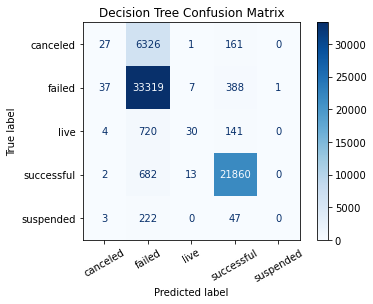

In [11]:
from sklearn import metrics

metrics.plot_confusion_matrix(decision_tree, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Decision Tree Confusion Matrix')
plt.xticks(rotation=30)
plt.show()

The confusion matrix shows that our model was pretty great at predicting which projects failed, did decently to predict which projects were successful, but everything lese, the model did a poor job of predicting correctly. For the most part, this isn't too bad, but for example, the 681 that were true successfuls, but our tree model predicted that it failed, that is an area we might be able tune a bit more for better results. 

In [12]:
print(metrics.classification_report(y_test, tree_y_pred))

#would focus on weighted average as the metric of choice

              precision    recall  f1-score   support

    canceled       0.37      0.00      0.01      6515
      failed       0.81      0.99      0.89     33752
        live       0.59      0.03      0.06       895
  successful       0.97      0.97      0.97     22557
   suspended       0.00      0.00      0.00       272

    accuracy                           0.86     63991
   macro avg       0.55      0.40      0.39     63991
weighted avg       0.81      0.86      0.81     63991



# Check for overfitting

In [13]:
# plot report for training set to see if there is overfitting, results usually should be exaclty the same if not overfit, 
# but if there are more than 5pts difference, then it is overfitting

In [14]:
y_train_pred = decision_tree.predict(X_train)

In [15]:
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

    canceled       0.68      0.01      0.02     25877
      failed       0.81      0.99      0.89    134751
        live       0.86      0.06      0.11      3543
  successful       0.97      0.97      0.97     90586
   suspended       1.00      0.01      0.01      1205

    accuracy                           0.87    255962
   macro avg       0.86      0.41      0.40    255962
weighted avg       0.86      0.87      0.82    255962



In [16]:
# don't believe there is overfitting, because the weighted average for both the test and training 
# sets are very similar, around 0.86. The scores for failed and successful categories also recieved 
# identical scores. 

# Feature Importance for Decision Tree 

<BarContainer object of 53 artists>

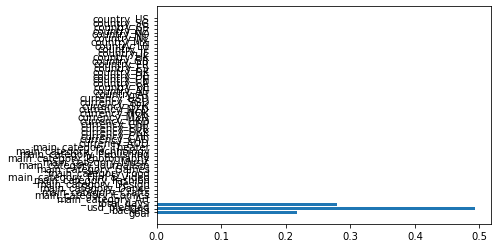

In [54]:
importances = decision_tree.feature_importances_
plt.barh(X_test.columns, importances)

#this is really hard to see with all the different features, but it looks like there are really only 3 that made a difference

Text(0.5, 1.0, 'Feature Importance for Decision Tree Model')

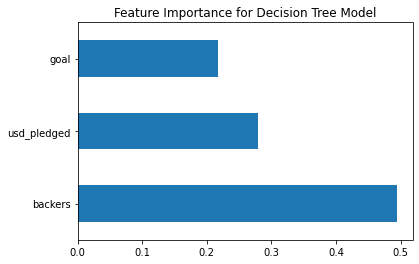

In [59]:
#let's separate the top 3 and plot those in terms of feature importance 
importances = pd.Series(importances, index=X_test.columns)
importances.nlargest(3).plot(kind = 'barh')
plt.title('Feature Importance for Decision Tree Model')

# very clear here that the number of backers, usd_pledged amount, and the goal amount are the influencers of the model. 
# our initial hypothesis that the main category, or even total days of project might have influence is proved false. 

# Adjusting model to unbalanced data 


In [17]:
#number of samples per class is not balanced, let's do something to balance it out
#imblearn from sklearn for data imbalances

In [18]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_os, y_os = sm.fit_resample(X, y)

In [19]:
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_os, y_os, test_size = 0.2, random_state = 42)

In [20]:
#refitting classifier with oversample data 
decision_tree.fit(X_train_os, y_train_os)
y_pred_os = decision_tree.predict(X_test_os)

In [21]:
print(metrics.classification_report(y_test_os, y_pred_os))

              precision    recall  f1-score   support

    canceled       0.39      0.37      0.38     33640
      failed       0.52      0.70      0.60     33582
        live       0.63      0.50      0.55     33794
  successful       0.85      0.90      0.88     33680
   suspended       0.55      0.48      0.52     33807

    accuracy                           0.59    168503
   macro avg       0.59      0.59      0.58    168503
weighted avg       0.59      0.59      0.58    168503



In [22]:
import imblearn
print(imblearn.metrics.classification_report_imbalanced(y_test, tree_y_pred))

                   pre       rec       spe        f1       geo       iba       sup

   canceled       0.37      0.00      1.00      0.01      0.06      0.00      6515
     failed       0.81      0.99      0.74      0.89      0.85      0.75     33752
       live       0.59      0.03      1.00      0.06      0.18      0.03       895
 successful       0.97      0.97      0.98      0.97      0.98      0.95     22557
  suspended       0.00      0.00      1.00      0.00      0.00      0.00       272

avg / total       0.81      0.86      0.85      0.81      0.80      0.73     63991



# Binary classification for Decision Tree

In [23]:
from sklearn import preprocessing 
y2 = preprocessing.label_binarize(y, classes = ['successful'])

In [24]:
#retraining classifier since the y is now binary class
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size = 0.2, random_state = 42)
decision_tree = decision_tree.fit(X_train2, y_train2)
tree_y_pred2 = decision_tree.predict(X_test2)

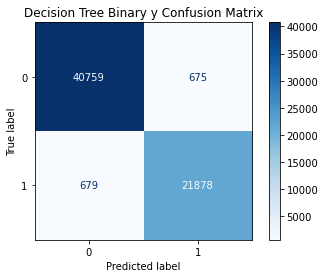

In [25]:
metrics.plot_confusion_matrix(decision_tree, X_test2, y_test2, cmap=plt.cm.Blues)
plt.title('Decision Tree Binary y Confusion Matrix')
plt.show()

In [26]:
print(metrics.classification_report(y_test2, tree_y_pred2))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     41434
           1       0.97      0.97      0.97     22557

    accuracy                           0.98     63991
   macro avg       0.98      0.98      0.98     63991
weighted avg       0.98      0.98      0.98     63991



If we compare the results of multicalss vs binary for the target variable, the 'successful' score is about the same at .97 for both precision and recall, but by creating a binary target variable, the precision and recall for nonpositive or 'failed/canceled, etc.' labels score is higher in precision. 

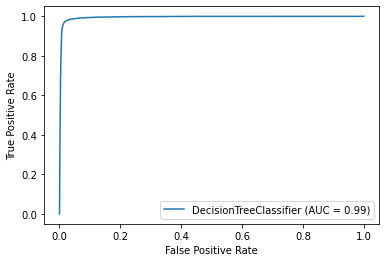

In [27]:
metrics.plot_roc_curve(decision_tree, X_test2, y_test2)
plt.show()

In [28]:
auc = metrics.roc_auc_score(y_test2, decision_tree.predict_proba(X_test2)[:,1])
print("AUC:",auc)

AUC: 0.994372667947362


# RandomForestClassifier 


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
forest = RandomForestClassifier()
#better to keep max depth flexible, and then gridsearch for n_estimators 

In [30]:
#can we use the same max depth as before? or should we do another gridsearch to figure it out for this classifier 

#param_grid = {'n_estimators': [50, 100]}
#forest_randomsearchcv = RandomizedSearchCV(forest, param_grid)
#forest_randomsearchcv.fit(X_train, y_train)
#forest_randomsearchcv.best_params_

In [31]:
forest = RandomForestClassifier(n_estimators = 100)

In [32]:
forest.fit(X_train, y_train)
forest_y_pred = forest.predict(X_test)

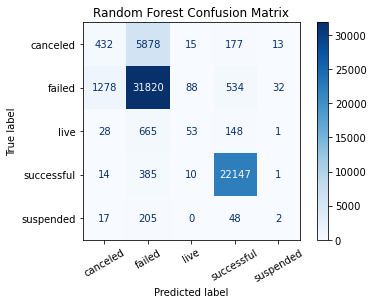

In [33]:
metrics.plot_confusion_matrix(forest, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.xticks(rotation=30)
plt.show()

In [34]:
print(metrics.classification_report(y_test, forest_y_pred))

              precision    recall  f1-score   support

    canceled       0.24      0.07      0.10      6515
      failed       0.82      0.94      0.88     33752
        live       0.32      0.06      0.10       895
  successful       0.96      0.98      0.97     22557
   suspended       0.04      0.01      0.01       272

    accuracy                           0.85     63991
   macro avg       0.48      0.41      0.41     63991
weighted avg       0.80      0.85      0.82     63991



# Balanced Random Forest Classifier

In [35]:
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators = 100)
brf.fit(X_train, y_train)
brf_y_pred = brf.predict(X_test)

In [36]:
print(metrics.classification_report(y_test, brf_y_pred))

              precision    recall  f1-score   support

    canceled       0.21      0.33      0.26      6515
      failed       0.88      0.42      0.57     33752
        live       0.08      0.51      0.13       895
  successful       0.91      0.90      0.90     22557
   suspended       0.01      0.40      0.02       272

    accuracy                           0.58     63991
   macro avg       0.42      0.51      0.38     63991
weighted avg       0.81      0.58      0.65     63991



Text(0.5, 1.0, 'Feature Importance for Random Forest')

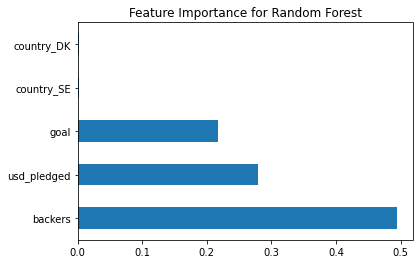

In [63]:
importances2 = forest.feature_importances_
importances2 = pd.Series(importances, index=X_test.columns)
importances2.nlargest(5).plot(kind = 'barh')
plt.title('Feature Importance for Random Forest')

#it looks like the same three features are listed in the Random Forest model

# Binary Classificaiton for Random Forest 

In [37]:
forest.fit(X_train2, y_train2)
forest_y_pred2 = forest.predict(X_test2)

<ipython-input-37-d391109edb05>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train2, y_train2)


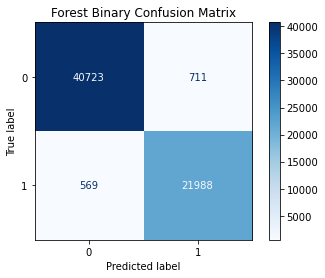

In [38]:
metrics.plot_confusion_matrix(forest, X_test2, y_test2, cmap=plt.cm.Blues)
plt.title('Forest Binary Confusion Matrix')
plt.show()

In [39]:
print(metrics.classification_report(y_test2, forest_y_pred2))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     41434
           1       0.97      0.97      0.97     22557

    accuracy                           0.98     63991
   macro avg       0.98      0.98      0.98     63991
weighted avg       0.98      0.98      0.98     63991



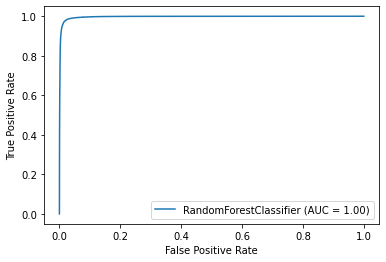

In [40]:
metrics.plot_roc_curve(forest, X_test2, y_test2)
plt.show()

In [41]:
auc = metrics.roc_auc_score(y_test2, forest.predict_proba(X_test2)[:,1])
print("AUC:",auc)

AUC: 0.9969969524882135
